# Tutorial 2: Data Parallel and Fully Sharded Data Parallel Training

[![Open in GitHub](https://img.shields.io/badge/Open%20in-GitHub-181717?style=flat-square&logo=github)](https://github.com/sshkhr/MinText/blob/main/docs/tutorials/2_Data_Parallel_and_FSDP.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sshkhr/MinText/blob/main/docs/tutorials/2_Data_Parallel_and_FSDP.ipynb)

In the previous tutorial, we explored the basics of JAX parallelization, including device meshes, sharded matrices, and collective operations. In this tutorial, we'll build on those concepts to explore the first parallelism strategy used in scaling models: data parallelism (DP). After data parallelism, we will learn about the second parallelism strategy used in scaling models: Fully Sharded Data Parallelism (FSDP).

**Learning objectives:**
- Understand data parallelism
- Learn about implementing neural networks in Flax
- Learn about the Fully Sharded Data Parallel (FSDP) strategy

**Prerequisites (covered in Tutorial 1):**
- Basic familiarity with JAX
- Understanding of JAX sharding
- Understanding of sharded matrix operations


## 0. Background

### 0.1 Setup

Let's start by importing the necessary libraries and initializing our environment.

In [1]:
import os
# Force JAX to use 8 GPU devices for this tutorial (only use if not using TPU runtime)
#os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'

import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
from jax.experimental import mesh_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial
import dataclasses

In [2]:
# Check available devices
print(f"JAX version: {jax.__version__}")
print(f"Available devices: {jax.devices()[:4]}...")
print(f"Number of devices: {jax.device_count()}")

JAX version: 0.5.2
Available devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1)]...
Number of devices: 8


### 0.2 Model Representation

For simplicity, we will start with a simple feed-forward model. The model consists of two fully-connected (or dense) layers:

- **W<sub>in</sub>**: `bf16[D, F]` (up-projection)
- **W<sub>out</sub>**: `bf16[F, D]` (down-projection)

And the input and output are defined as:
- **Input**: `bf16[B, D]`
- **Out**: `bf16[B, D]`

Where:
- **D** = d<sub>model</sub> (input/output dimension)
- **F** = d<sub>ff</sub> (feed-forward or hidden dimension)
- **B** = batch size (total tokens)


![MLP](https://github.com/jax-ml/scaling-book/blob/main/assets/img/simple-transformer.png?raw=true)

<sup> Image Source: [How To Scale Your Model](https://jax-ml.github.io/scaling-book) </sup>

### 0.3 Why Parallelism?

As we scale up our models and datasets, we need to distribute the computation across multiple devices in order to train these models in reasonable periods of time. For example, 2048 A100 GPUs were used to train LLaMa. If they were to train LLama 3 8B model (the smallest Llama 3 model) on a single A100 GPU, it would take approximately 1.46 million hours (or 166 years) to complete the training. This is why we need parallelism.

We also want to optimize the time spent doing various computations in the training process - since some operations are independent of each other, we can spread them across multiple devices to speed up the training process. We will see more examples of this when we discuss each training strategy.


### 0.4 Communication vs Computation Trade-offs

The goal of scaling is to achieve **strong scaling**, a linear increase in throughput with more chips. In order to achieve good scaling performance, parallel algorithms are designed to hide inter-chip communication by overlapping it with useful FLOPs.

Let $T_\text{ops}$ represent the time spent on computation (FLOPs) and $T_{\text{comms}}$ represent the time spent on communication (data transfer). For the purpose of this tutorial, let us ignore intra-chip communication cost and focus on inter-chip communication costs (although in the real world, you would consider both - but let's assume that intra-chip communication and computation overlap have already been optimized).

The ratio of these two times ($T_\text{ops}$ and $T_{\text{comms}}$) is crucial for determining the efficiency of our parallel training:

An algorithm become **compute-bound** when:

$$\frac{T_{\text{ops}}}{T_{\text{comms}}} > 1$$

This means that the time spent on computation is greater than the time spent on communication, and we can achieve good scaling performance by hiding communication time between the time spend on computation. Let us see what this means in practice.

## 2. Data Parallel

Data parallelism (DP) is a parallelization strategy where we split the input data batch across multiple devices, allowing each device to compute on a different subset of the data. This is particularly useful for large datasets that cannot fit into the memory of a single device. When the model is small enough to fit on a single device, we can use data parallelism to scale up the training by distributing the data across multiple devices.

### 2.1 Data Parallelism Theory

**Sharding**: Input data and model activations are sharded along batch dimension across devices, model parameters are replicated on each device.

**Equation** (for our MLP example):
$$\text{In}[B_X, D] \cdot_D W_{\text{in}}[D, F] \cdot_F W_{\text{out}}[F, D] \rightarrow \text{Out}[B_X, D]$$

where $B_X$ indicates the batch is sharded across $X$ devices.

![Data Parallelism](https://github.com/jax-ml/scaling-book/blob/main/assets/img/data-parallelism.png?raw=true)

<sup> Image Source: [How To Scale Your Model](https://jax-ml.github.io/scaling-book) </sup>

## 3. Example: 8-way Data Parallel Training with Plain JAX

### 3.1 Create dataset and define model

First, let's generate our synthetic dataset and simple feed-forward neural network.

In [3]:
def get_linear_layer(key, dim_in, dim_hidden):
  k1, k2 = jax.random.split(key)
  W = jax.random.normal(k1, (dim_in, dim_hidden)) / jnp.sqrt(dim_in)
  b = jax.random.normal(k2, (dim_hidden,))
  return W, b

def get_model_and_data(key, layer_sizes, batch_size):
  keys, *keys = jax.random.split(key, len(layer_sizes))

  model = list(map(get_linear_layer, keys, layer_sizes[:-1], layer_sizes[1:]))
  # The model is just a list of linear layers. A more readable version of the above is:
  # model = [
  #    get_linear_layer(k, in_dim, out_dim)
  #    for k, in_dim, out_dim in zip(keys, layer_sizes[:-1], layer_sizes[1:])
  #]

  keys, *keys = jax.random.split(key, 2)
  input_data = jax.random.normal(keys[0], (batch_size, layer_sizes[0]))
  target_data = jax.random.normal(keys[0], (batch_size, layer_sizes[-1]))

  # data is just random numbers for both inputs and outputs

  return model, (input_data, target_data)

We will use a simple feed-forward neural network with two linear layers, as described in the background section. The input and output dimensions are set to 128, which is a common choice of hidden dimension in transformer models. The batch size is set to 8192.

In [4]:
# A simple sqeuence-modelling architecture: 128 -> 2048 -> 2048 -> 128
layer_sizes = [128, 2048, 2048, 128]
batch_size = 8192

In [5]:
model, batch = get_model_and_data(jax.random.key(0), layer_sizes, batch_size)

Now we define our model's forward pass and loss function. We are using JAX for now, so this might seem a bit verbose if you are coming from PyTorch or TensorFlow, but we will see how to simplify the neural network modelling with Flax in the next section.

In [6]:
def predict(model, inputs):
  for W, b in model:
    outputs = jnp.dot(inputs, W) + b
    inputs = jnp.maximum(outputs, 0) # ReLU activation
  return outputs

def loss(model, batch):
  inputs, targets = batch
  predictions = predict(model, inputs)
  return jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))

Finally, we will compile our model using `jax.jit` to utilize JAX compiler to optimize the performance of our forward and backward pass.

In [7]:
loss_jit = jax.jit(loss)
gradfun = jax.jit(jax.grad(loss))

### 3.2 Single-Device Baseline

Let's first establish a baseline by training on a single device.

In [8]:
batch_single = jax.device_put(batch, jax.devices()[0])
params_single = jax.device_put(model, jax.devices()[0])

In [9]:
loss_jit(params_single, batch_single)

Array(435.76917, dtype=float32)

In [10]:
%timeit -n 5 -r 5 gradfun(params_single, batch_single)[0][0].block_until_ready()

The slowest run took 19.58 times longer than the fastest. This could mean that an intermediate result is being cached.
55.8 ms ± 87.8 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


### 3.3 8-way Data Parallel Training

Now let's implement 8-way data parallel training where we'll shard the batch across 8 devices.

In [11]:
# Create an 8-device mesh for data parallelism
mesh = jax.make_mesh((8,), ('batch',))
print(f"Mesh shape: {mesh.shape}")
print(f"Mesh axis names: {mesh.axis_names}")

# Create sharding specifications

## Shard data along the batch dimension
batch_sharding = NamedSharding(mesh, P('batch'))
## Replicate parameters across all devices
replicated_sharding = NamedSharding(mesh, P())

Mesh shape: OrderedDict([('batch', 8)])
Mesh axis names: ('batch',)


We shard our batch along `batch` dimension, while our model is replicated across all devices.

In [12]:
batch = jax.device_put(batch, batch_sharding)
params = jax.device_put(model, replicated_sharding)

Let's visualize how the batch is sharded across devices.

In [13]:
print("Visualizing batch sharding across 8 devices:")
print("Original batch shape:", batch[0].shape)

for shard in batch[0].addressable_shards:
  print(shard.device, shard.index[0], shard.data.shape)

jax.debug.visualize_array_sharding(batch[0])

Visualizing batch sharding across 8 devices:
Original batch shape: (8192, 128)
TPU_0(process=0,(0,0,0,0)) slice(0, 1024, None) (1024, 128)
TPU_1(process=0,(0,0,0,1)) slice(1024, 2048, None) (1024, 128)
TPU_2(process=0,(1,0,0,0)) slice(2048, 3072, None) (1024, 128)
TPU_3(process=0,(1,0,0,1)) slice(3072, 4096, None) (1024, 128)
TPU_6(process=0,(1,1,0,0)) slice(4096, 5120, None) (1024, 128)
TPU_7(process=0,(1,1,0,1)) slice(5120, 6144, None) (1024, 128)
TPU_4(process=0,(0,1,0,0)) slice(6144, 7168, None) (1024, 128)
TPU_5(process=0,(0,1,0,1)) slice(7168, 8192, None) (1024, 128)


  TPU 0  
         
  TPU 1  
         
  TPU 2  
         
  TPU 3  
         
  TPU 6  
         
  TPU 7  
         
  TPU 4  
         
  TPU 5  
         

In [14]:
loss_jit(params, batch)

Array(435.7692, dtype=float32)

In [15]:
%timeit -n 5 -r 5 gradfun(params, batch)[0][0].block_until_ready()

The slowest run took 79.22 times longer than the fastest. This could mean that an intermediate result is being cached.
61.1 ms ± 115 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [16]:
step_size = 1e-5
losses = []

for step in range(30):
  grads = gradfun(params, batch)
  params = [(W - step_size * dW, b - step_size * db)
            for (W, b), (dW, db) in zip(params, grads)]

  current_loss = loss_jit(params, batch)
  losses.append(float(current_loss))

  if step % 5 == 0:
    print(f"Step {step}, loss: {current_loss:.6f}")

print(f"\nFinal loss: {loss_jit(params, batch):.6f}")

Step 0, loss: 409.836945
Step 5, loss: 312.069946
Step 10, loss: 251.479156
Step 15, loss: 213.499405
Step 20, loss: 189.462906
Step 25, loss: 174.309052

Final loss: 166.210480


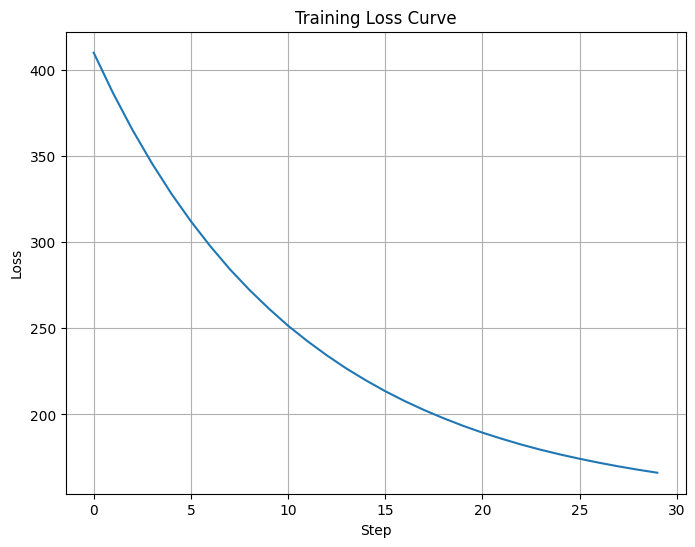

In [17]:
# Visualize the loss curve
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

## 4. Data Parallel Algorithm

One of the key advantages of data parallelism is that there is no communication between devices during the forward pass. Each device computes its own forward pass independently on the sharded batch without moving any data around.

### 4.1 Forward pass

1. Tmp[B<sub>X</sub>, F] = In[B<sub>X</sub>, D] ×<sub>D</sub> W<sub>in</sub>[D, F]
2. Out[B<sub>X</sub>, D] = Tmp[B<sub>X</sub>, F] ×<sub>F</sub> W<sub>out</sub>[F, D]
3. Loss[B<sub>X</sub>] = ...

In the backward pass, we need the gradients from the full batch across all devices. In order to do so, we first compute the gradients for each device (Steps 2 and 5 below). However, these are only the gradients for the sharded batch on each device. To compute the gradients for the full batch, we need to aggregate the gradients across all devices (Steps 3 and 6 below). This is done with `AllReduce` operation on the gradients from all devices.

One important thing to note is that the backward pass computation for the current iteration does not involve the collected gradients from this iteration. We say that the gradient accumulation in the backward passs is not on a **critical path** - the rest of the backward pass can continue while the gradients are being communicated. This means that we can overlap the communication of the gradients with the computation on each device. This is crucial for achieving good scaling performance.

### 4.2 Backward pass

1.  dOut[B<sub>X</sub>, D] = ...
2.  dW<sub>out</sub>[F, D] {U<sub>X</sub>} = Tmp[B<sub>X</sub>, F] \*<sub>B</sub> dOut[B<sub>X</sub>, D]
3.  dW<sub>out</sub>[F, D] = **AllReduce**(dW<sub>out</sub>[F, D] {U<sub>X</sub>}) (*not on critical path, can be done async*)
4.  dTmp[B<sub>X</sub>, F] = dOut[B<sub>X</sub>, D] \*<sub>D</sub> W<sub>out</sub>[F, D]
5.  dW<sub>in</sub>[D, F] {U<sub>X</sub>} = In[B<sub>X</sub>, D] \*<sub>B</sub> dTmp[B<sub>X</sub>, F]
6.  dW<sub>in</sub>[D, F] = **AllReduce**(dW<sub>in</sub>[D, F] {U<sub>X</sub>}) (*not on critical path, can be done async*)
7.  dIn[B<sub>X</sub>, D] = dTmp[B<sub>X</sub>, F] \*<sub>F</sub> W<sub>in</sub>[D, F] (*needed for previous layers*)

### 4.3 Compute Bound versus Communication Bound

As we can see above, we have two AllReduces per layer, each of size $$2DF$$ (for bf16 weights). When does data parallelism make us communication bound?

Let $C$ = per-chip FLOPs, $W_{\text{ici}}$ = **bidirectional** network bandwidth, and $X$ = number of shards across which the batch is partitioned. Let's calculate the time required to perform the relevant matmuls (compute time), $T_\text{math}$, and the required communication time $T_\text{comms}$.  Since this parallelism scheme requires no communication in the forward pass, we only need to calculate these quantities for the backwards pass.

#### Communication time

Time required to perform an AllReduce in a 1D mesh depends only on the total bytes of the array being AllReduced and the ICI bandwidth $W_\text{ici}$; specifically the AllReduce time is $2 \cdot \text{total bytes} / W_\text{ici}$. Since we need to AllReduce for both $W_\text{in}$ and $W_\text{out}$, we have 2 AllReduces per layer.  Each AllReduce is for a weight matrix, i.e. an array of $DF$ parameters, or $2DF$ bytes. Putting this all together, the total time for the AllReduce in a single layer is

$$\begin{align}
T_\text{comms} &= \frac{2 \cdot 2 \cdot 2 \cdot D \cdot F}{W_\text{ici}}. \\
\end{align}$$

#### Computation time

Each layer comprises two matmuls in the forward pass, or four matmuls in the backwards pass, each of which requires $2(B/X)DF$ FLOPs. Thus, for a single layer in the backward pass, we have

$$\begin{align}
T_\text{math} &= \frac{2 \cdot 2 \cdot 2 \cdot B \cdot D \cdot F}{X \cdot C} \\
\end{align}$$

Since we overlap, the total time per layer is the max of these two quantities:

$$\begin{aligned}
T &\approx \max(\frac{8 \cdot B \cdot D \cdot F}{X \cdot C}, \frac{8 \cdot D \cdot F}{W_\text{ici}}) \\
T &\approx 8 \cdot D \cdot F \cdot \max(\frac{B}{X \cdot C}, \frac{1}{W_\text{ici}})
\end{aligned}$$

We become compute-bound when $T_\text{math}/T_\text{comms} > 1$, or when $\frac{B}{X} > \frac{C}{W_\text{ici}}.$

The upshot is that, to remain compute-bound with data parallelism, we need the per-device batch size $$B / X$$ to exceed the ICI operational intensity, $C / W_\text{ici}$. This is ultimately a consequence of the fact that the computation time scales with the per-device batch size, while the communication time is independent of this quantity (since we are transferring model weights).

For TPU v2 pods, we follow the same analytical framework to determine when data parallelism becomes communication-bound.

**TPU v2 Specifications:**
- Per-chip compute: C = 4.5e13 FLOPS (45 TFLOPS at bfloat16)
- ICI bandwidth: W_ici = 2.48e11 bytes/s (4 links @ 496 Gbits/s per direction = 248 GB/s unidirectional)
- 2D torus topology connecting up to 256 chips

**Critical Condition:**
Data parallelism remains compute-bound when the per-device batch size exceeds:

$$\frac{B}{X} > \frac{C}{W_{ici}} = \frac{4.5 \times 10^{13}}{2.48 \times 10^{11}} \approx 181$$

**Key Results:**
- **Minimum batch size per chip: ~181 tokens** to avoid communication bottleneck
- For a full 256-chip TPU v2 pod, this translates to a minimum global batch size of ~46K tokens


**Practical Implications:**
The relatively low threshold of 181 tokens per chip makes TPU v2 pods well-suited for typical training workloads. **This tells us that it's fairly hard to become bottlenecked by pure data parallelism!** Most production models use batch sizes well above this threshold, ensuring efficient utilization without communication bottlenecks during data-parallel training.

## 5. Data Parallel Training with Flax NNX

While JAX has its own advantages, it is often too low level of an API when implementing neural networks. For people familiar with PyTorch, the JAX ecosystem offers [Flax](https://flax.readthedocs.io/en/latest/) - a neural network modelling library with an API much more similar to that offered by PyTorch. Let's implement the same 8-way data parallel training using the Flax NNX API, which provides higher-level abstractions.

### 5.1 Import Flax

We need to import (or install) the `flax` library, which provides a high-level API for building neural networks in JAX called `nnx` (analogous to `torch.nn` API in PyTorch).


In [18]:
# Import Flax NNX
try:
    import flax.nnx as nnx
    import optax
except ImportError:
    !pip install -q flax optax
    import flax.nnx as nnx
    import optax

### 5.2 Define Model using Flax NNX API

We define our two layer model as before, but using the flax `nnx.Module` API.

In [19]:
class MLP(nnx.Module):
  def __init__(self, din, dmid, dout, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
    self.linear2 = nnx.Linear(dmid, dout, rngs=rngs)

  def __call__(self, x):
    x = nnx.relu(self.linear1(x))
    return self.linear2(x)

### 5.3 Replicate Model and Optimizer State across devices

We replicated the model and optimizer state across the replicated sharding we defined earlier.

In [20]:
model = MLP(128, 2048, 128, rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adamw(1e-2))

# replicate model and optimizer states across shards
state = nnx.state((model, optimizer))
state = jax.device_put(state, replicated_sharding)
nnx.update((model, optimizer), state)

In [21]:
# visualize model sharding
print('model sharding')
jax.debug.visualize_array_sharding(model.linear1.kernel.value)

model sharding


                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                              TPU 0,1,2,3,4,5,6,7                               
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                

### 5.4 Define Train Step

Simple MSE loss

In [22]:
@nnx.jit
def train_step(model: MLP, optimizer: nnx.Optimizer, x, y):
  def loss_fn(model: MLP):
    y_pred = model(x)
    return jnp.mean((y - y_pred) ** 2)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)
  return loss

### 5.5 Distributed Training

In order to simulate sequence modelling, we will use a synthetic dataset of sequences which are random weighted sums of periodic functions (sin and cosine).

In [23]:
def dataset(steps, batch_size):
  """Generate 128D sequence data with underlying pattern."""
  for _ in range(steps):
    # Generate input sequences
    # Create a pattern where the output is a transformed version of input
    # First few dimensions have strong pattern, rest have weaker signal

    # Generate base signal
    t = np.linspace(0, 4*np.pi, 128)
    base_patterns = np.array([
      np.sin(t + np.random.uniform(0, 2*np.pi)),
      np.cos(2*t + np.random.uniform(0, 2*np.pi)),
      np.sin(3*t + np.random.uniform(0, 2*np.pi))
    ])

    # Create batch of sequences
    x = np.zeros((batch_size, 128))
    y = np.zeros((batch_size, 128))

    for i in range(batch_size):
      # Mix base patterns with random weights
      weights = np.random.randn(3)
      signal = np.sum(weights[:, np.newaxis] * base_patterns, axis=0)

      # Add noise
      x[i] = signal + np.random.normal(0, 0.1, 128)

      # Output is a non-linear transformation of input
      # Shift and apply non-linear transformation
      y[i] = np.roll(x[i], 5) * 0.8 + 0.1 * x[i]**2
      y[i] += np.random.normal(0, 0.05, 128)

    yield x.astype(np.float32), y.astype(np.float32)

We can visualize a sample from the dataset to see what it looks like.

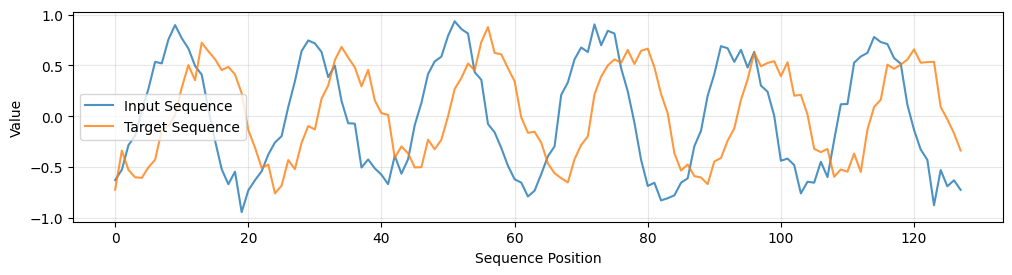

In [24]:
x, y = next(dataset(1, 1))

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x[0], label='Input Sequence', alpha=0.8)
plt.plot(y[0], label='Target Sequence', alpha=0.8)
plt.xlabel('Sequence Position')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

In [30]:
# Training parameters
batch_size = 8192
num_steps = 1000
losses = []

In [31]:
for step, (x, y) in enumerate(dataset(num_steps, batch_size)):
  # shard data
  x, y = jax.device_put((x, y), batch_sharding)
  # train
  loss = train_step(model, optimizer, x, y)

  if step == 0:
    print('data sharding')
    jax.debug.visualize_array_sharding(x)

  if step % 100 == 0:
    print(f'step={step}, loss={loss}')

data sharding


  TPU 0  
         
  TPU 1  
         
  TPU 2  
         
  TPU 3  
         
  TPU 6  
         
  TPU 7  
         
  TPU 4  
         
  TPU 5  
         

step=0, loss=0.04116662219166756
step=100, loss=0.02114887908101082
step=200, loss=0.01878426969051361
step=300, loss=0.03063983842730522
step=400, loss=0.020617207512259483
step=500, loss=0.025628481060266495
step=600, loss=0.04745261371135712
step=700, loss=0.044706568121910095
step=800, loss=0.08527882397174835
step=900, loss=0.0209338515996933


In [32]:
# dereplicate state
state = nnx.state((model, optimizer))
state = jax.device_get(state)
nnx.update((model, optimizer), state)

We can now visualize the training loss curve, as well as the sequence model learned by our data parallel training.

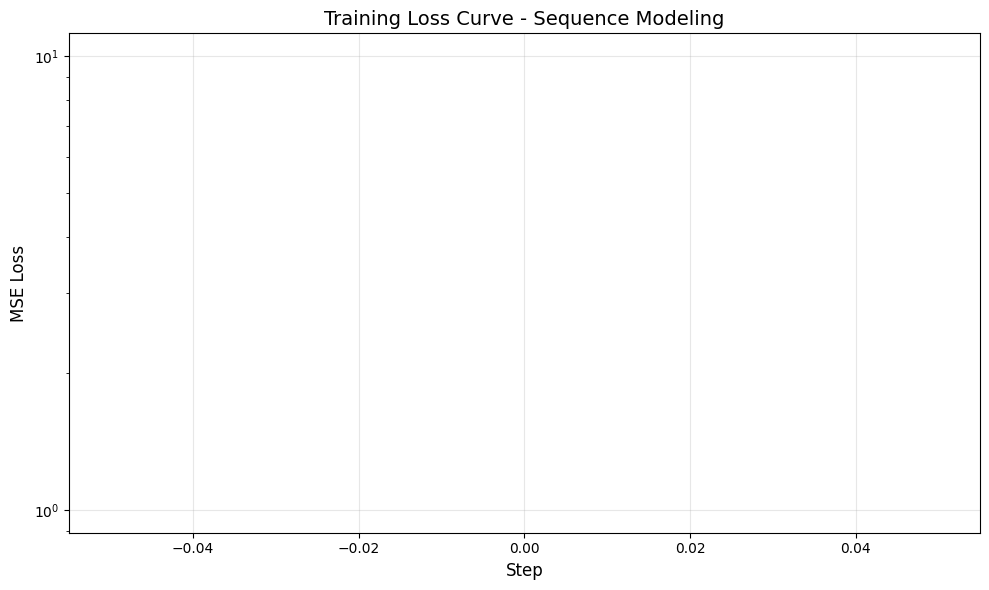

In [33]:
# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, linewidth=2)
plt.xlabel('Step', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training Loss Curve - Sequence Modeling', fontsize=14)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to better see the decrease
plt.tight_layout()
plt.show()

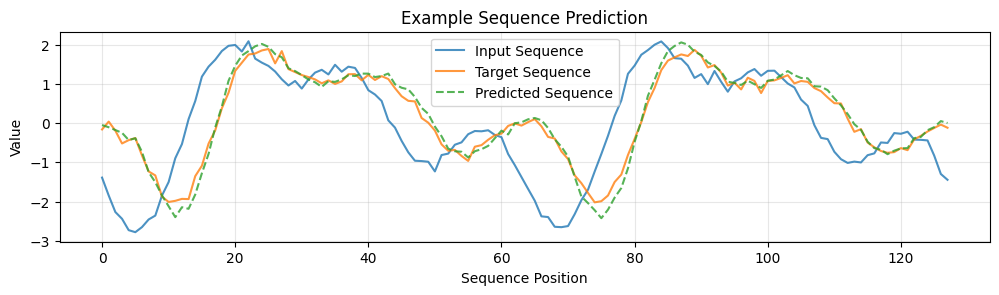

In [34]:
x_test, y_test = next(dataset(1, 1))
y_pred = model(x_test)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x_test[0], label='Input Sequence', alpha=0.8)
plt.plot(y_test[0], label='Target Sequence', alpha=0.8)
plt.plot(y_pred[0], label='Predicted Sequence', linestyle='--', alpha=0.8)
plt.xlabel('Sequence Position')
plt.ylabel('Value')
plt.title('Example Sequence Prediction')
plt.legend()
plt.grid(True, alpha=0.3)

## 5. Fully Sharded Data Parallelism (FSDP)

### 5.1 What limits Data Parallelism?

Data Parallelism involves a lot of duplicated work. Once each device AllReduces the gradients, each device updates:

- full optimzer state (duplicated across all devices)
- full parameter update for the model (duplicated across all devices)

### 5.2 ZeRO (Zero Redundancy Optimizer)

The paper ZeRO: Memory Optimizations Toward Training Trillion Parameter Models (linked below) the memory optimizations by sharding not just the data along the batch axis, but also sharding the optimizer states (e.g. momentum vector), gradients, as well as the parameters.

The rows below show the memory consumption of:
1. **Pure Data Parallelism**: Parameters and optimizer states fully replicated
2. **ZeRO-1**: Optimizer states sharded
3. **ZeRO-2**: Optimizer states and gradients sharded  
4. **ZeRO-3**: Parameters, gradients, and optimizer states all sharded

![FSDP Memory Comparison](https://github.com/jax-ml/scaling-book/blob/main/assets/img/fsdp-figure.png?raw=true)

<sup> Image Source: [ZeRO: Memory Optimizations Toward Training Trillion Parameter Models](https://arxiv.org/abs/1910.02054) </sup>



### 5.3 FSDP Theory

**Definition**: ZeRO-3 is also known as Fully Sharded Data Parallel since activations, weights, and optimizer states are sharded along batch dimension. Weights are gathered just-in-time before use.

**Mathematical representation**:
$$\text{In}[B_X, D] \cdot_D W_{\text{in}}[D_X, F] \cdot_F W_{\text{out}}[F, D_X] \rightarrow \text{Out}[B_X, D]$$

where both batch and weight dimensions are sharded across $X$ devices.

![FSDP](https://github.com/jax-ml/scaling-book/blob/main/assets/img/fsdp.png?raw=true)

<sup> Image Source: [How To Scale Your Model](https://jax-ml.github.io/scaling-book) </sup>

### 5.3 FSDP Algorithm

As mentioned earlier, data parallelism involves a lot of duplicated work. Fully Sharded Data Parallelism (FSDP) addresses this by sharding the model weights and activations across devices. Instead of using AllReduce to communicate the full model weights and optimizer states, FSDP splits the AllReduce operation into two steps: **AllGather** and **ReduceScatter**. See the previous tutorial on how this is mathematically equivalent.

Splitting the collective allows us to gather the weights from all devices just-in-time before use, and scatter the gradients back to each device after the backward pass. While this adds extra communication during the forward pass compared to data parallelism, but its in proportion to the reduction in comms during the backward pass - so the overall communication cost is same.

**Forward pass:**
1.  W<sub>in</sub>[D, F] = **AllGather**(W<sub>in</sub>[D<sub>X</sub>, F]) (*not on critical path, can do it during previous layer*)
2.  Tmp[B<sub>X</sub>, F] = In[B<sub>X</sub>, D] \*<sub>D</sub> W<sub>in</sub>[D, F] (*can throw away W<sub>in</sub>[D, F] now*)
3.  W<sub>out</sub>[F, D] = **AllGather**(W<sub>out</sub>[F, D<sub>X</sub>]) (*not on critical path, can do it during previous layer*)
4.  Out[B<sub>X</sub>, D] = Tmp[B<sub>X</sub>, F] \*<sub>F</sub> W<sub>out</sub>[F, D]
5.  Loss[B<sub>X</sub>] = ...

**Backward pass:**
1.  dOut[B<sub>X</sub>, D] = ...
2.  dW<sub>out</sub>[F, D] {U<sub>X</sub>} = Tmp[B<sub>X</sub>, F] \*<sub>B</sub> dOut[B<sub>X</sub>, D]
3.  dW<sub>out</sub>[F, D<sub>X</sub>] = **ReduceScatter**(dW<sub>out</sub>[F, D] {U<sub>X</sub>}) (*not on critical path, can be done async*)
4.  W<sub>out</sub>[F, D] = **AllGather**(W<sub>out</sub>[F, D<sub>X</sub>]) (*can be done ahead of time*)
5.  dTmp[B<sub>X</sub>, F] = dOut[B<sub>X</sub>, D] \*<sub>D</sub> W<sub>out</sub>[F, D] *(can throw away W<sub>out</sub>[F, D] here)*
6.  dW<sub>in</sub>[D,F] {U<sub>X</sub>} = dTmp[B<sub>X</sub>, F] \*<sub>B</sub> In[B<sub>X</sub>, D]
7.  dW<sub>in</sub>[D<sub>X</sub>, F] = **ReduceScatter**(dW<sub>in</sub>[D, F] {U<sub>X</sub>}) *(not on critical path, can be done async)*
8.  W<sub>in</sub>[D, F] = **AllGather**(W<sub>in</sub>[D<sub>X</sub>, F]) (*can be done ahead of time*)
9.  dIn[B<sub>X</sub>, D] = dTmp[B<sub>X</sub>, F] \*<sub>F</sub> W<sub>in</sub>[D, F] (*needed for previous layers) (can throw away W<sub>in</sub>[D, F] here*)

![Data Parallel](https://engineering.fb.com/wp-content/uploads/2021/07/FSDP-Graph-2.png)

<sup> Image Source: [FB Engineering Blog](https://engineering.fb.com/2021/07/15/open-source/fsdp/) </sup>

### 5.5 FSDP Compute versus Communication Bound

**Communication Analysis**:

FSDP has the **same roofline as pure data parallelism** because:
- AllReduce = AllGather + ReduceScatter
- Total communication volume is identical
- Same condition: $\frac{B}{X} > \frac{C}{W_{\text{ici}}} = 2550$

## 6. Fully Sharded Data Parallel (FSDP) Training with Flax NNX

Now let's implement FSDP using the Flax NNX API.

### 6.1 Mesh and Sharding

In [ ]:
# Create a 1D mesh for FSDP
fsdp_mesh = jax.sharding.Mesh(
  mesh_utils.create_device_mesh(8),  # 1D mesh
  ('fsdp',)  # Single axis for FSDP
)

FSDP mesh shape: OrderedDict([('data', 2), ('model', 4)])
FSDP mesh axis names: ('data', 'model')


In [ ]:
# A helper function to quickly create a NamedSharding object
# using the globally defined 'mesh'.
def named_sharding(*names: str | None) -> NamedSharding:
  return NamedSharding(fsdp_mesh, P(*names))

In [ ]:
# A dataclass to hold sharding rules for different parts of the model/data.
# Makes it easy to manage and change sharding strategies.
@dataclasses.dataclass(unsafe_hash=True)
class FSDPRules:
  """Rules for FSDP sharding - all parameters sharded along the same axis"""
  weight_0: str | None = 'fsdp'  # Shard first dimension of weights
  weight_1: str | None = None     # Don't shard second dimension
  bias: str | None = None         # Don't shard biases (they're small)
  data: str | None = 'fsdp'       # Shard data along batch dimension

  def __call__(self, *keys: str) -> tuple[str, ...]:
    return tuple(getattr(self, key) for key in keys)


fsdp_rules = FSDPRules()

### 6.2 Build the Sharded Model

In [ ]:
# Define the MLP using Flax NNX API.
class MLP(nnx.Module):
  # Constructor takes input/hidden/output dimensions and an NNX Rngs object.
  def __init__(self, din, dmid, dout, rngs: nnx.Rngs):
    # Define the first weight matrix as an nnx.Param.
    self.w1 = nnx.Param(
      # Initialize with lecun_normal initializer using a key from rngs.
      nnx.initializers.lecun_normal()(rngs.params(), (din, dmid)),
      # CRITICAL: Specify the desired sharding using MeshRules.
      # ('weight_0', 'weight_1') -> ('fsdp', None) -> Shard dim 0 along fsdp axis, replicate dim 1.
      sharding=fsdp_rules('weight_0', 'weight_1'),  # ('fsdp', None)
    )
    self.b1 = nnx.Param(
      jnp.zeros((dmid,)),
      sharding=fsdp_rules('bias'),  # (None,) - biases are small, often not sharded
    )
    self.w2 = nnx.Param(
      nnx.initializers.lecun_normal()(rngs.params(), (dmid, dout)),
       # Sharding: ('weight_0', 'weight_1') -> ('fsdp', None) -> Replicate dim 0, shard dim 1 along 'model' axis.
      sharding=fsdp_rules('weight_0', 'weight_1'),  # ('fsdp', None)
    )
    # Note: No second bias b2 is defined in this simple example.

  # The forward pass of the MLP.
  def __call__(self, x: jax.Array):
    # Standard MLP calculation: (x @ W1 + b1) -> ReLU -> @ W2
    # NNX automatically accesses the .value attribute of nnx.Param objects.
    return nnx.relu(x @ self.w1 + self.b1) @ self.w2


### 6.2 Build the Sharded Optimizer

In [ ]:
# Define a custom type for SGD momentum state, inheriting from nnx.Variable.
# This allows it to be tracked as part of the NNX state tree.
class SGDState(nnx.Variable):
  pass

# Define the SGD optimizer using NNX API.
class SGD(nnx.Object):
  # Constructor takes the model parameters (as nnx.State), learning rate, and decay.
  def __init__(self, params: nnx.State, lr, decay=0.9):
    # Helper function to initialize momentum buffer for a given parameter.
    def init_optimizer_state(variable: nnx.Variable):
      # Create momentum state with zeros, same shape and metadata (incl. sharding)
      # as the parameter it corresponds to.
      return SGDState(
        jnp.zeros_like(variable.value), **variable.get_metadata()
      )

    self.lr = lr
    # Store a reference to the parameter State tree.
    self.params = params
    # Create the momentum state tree, mirroring the structure of 'params',
    # using the helper function. Momentum will have the same sharding as params.
    self.momentum = jax.tree.map(init_optimizer_state, self.params)
    self.decay = decay

  # Method to update parameters based on gradients.
  def update(self, grads: nnx.State):
    # Define the update logic for a single parameter/momentum/gradient triple.
    def update_fn(
      params: nnx.Variable, momentum: SGDState, grad: nnx.VariableState
    ):
      # Standard SGD with momentum update rule.
      # v_t = β * v_{t-1} + (1 - β) * ∇J(θ_t)
      momentum.value = self.decay * momentum.value + (1 - self.decay) * grad.value
      # θ_{t+1} = θ_t - α * v_t
      params.value -= self.lr * momentum.value # NOTE: Direct mutation of param value!

    # Apply the update function across the parameter, momentum, and gradient trees.
    # This performs the update in-place on the parameter values referenced by self.params.
    jax.tree.map(update_fn, self.params, self.momentum, grads)


### 6.3 Enforce Sharding in Model and Optimizer States

In [ ]:
# JIT-compile the model and optimizer creation function.
@nnx.jit
def create_model():
  # Instantiate the MLP model. rngs=nnx.Rngs(0) provides PRNG keys.
  model = MLP(1, 32, 1, rngs=nnx.Rngs(0))
  # Create the optimizer. nnx.variables(model, nnx.Param) extracts
  # only the nnx.Param state variables from the model object.
  optimizer = SGD(nnx.variables(model, nnx.Param), 0.01, decay=0.9)

  # === Explicit Sharding Application ===
  # 1. Extract ALL state (model params + optimizer momentum) into a flat State pytree.
  state = nnx.state(optimizer)

  # 2. Define the target sharding for the state pytree.
  # This function maps state paths to NamedSharding objects based on stored metadata.
  def get_named_shardings(path: tuple, value: nnx.VariableState):
    # Assumes params and momentum use the sharding defined in their metadata.
    if path[0] == 'params':
      # value.sharding contains the tuple like ('model',) or (None, 'model')
      return value.replace(NamedSharding(fsdp_mesh, P(*value.sharding)))
    elif path[0] == 'momentum':
      # Momentum states have the same sharding as their corresponding parameters
      return value.replace(NamedSharding(mesh, P(*value.sharding)))
    else:
      # Handle other state if necessary (e.g., learning rate if it were a Variable)
      raise ValueError(f'Unknown path: {path}')

  # Create the pytree of NamedSharding objects.
  named_shardings = state.map(get_named_shardings)

  # 3. Apply sharding constraint. This tells JAX how the 'state' pytree
  # SHOULD be sharded when computations involving it are run under jit/pjit.
  # It doesn't immediately move data but sets up the constraint for the compiler.
  sharded_state = jax.lax.with_sharding_constraint(state, named_shardings)

  # 4. Update the original objects (model params, optimizer momentum)
  # with the constrained state values. This step makes the sharding
  # "stick" to the objects themselves for subsequent use outside this function.
  nnx.update(optimizer, sharded_state)

  # Return the model and optimizer objects, now containing sharded state variables.
  return model, optimizer

# Call the function to create the sharded model and optimizer.
model, optimizer = create_model()

# Visualize the sharding of the first weight's parameter tensor.
jax.debug.visualize_array_sharding(model.w1.value)
# Visualize the sharding of the first weight's momentum tensor.
jax.debug.visualize_array_sharding(optimizer.momentum.w1.value)


### 6.4 Distributed Training

In [ ]:
# JIT-compile the training step function.
@nnx.jit
def train_step(model: MLP, optimizer: SGD, x, y):
  # Define the loss function (Mean Squared Error).
  # Takes the model object as input, consistent with nnx.value_and_grad.
  def loss_fn(model):
    y_pred = model(x) # Forward pass
    loss = jnp.mean((y - y_pred) ** 2)
    return loss

  # Calculate loss and gradients w.r.t the model's state (its nnx.Param variables).
  # 'grad' will be an nnx.State object mirroring model's Param structure.
  loss, grad = nnx.value_and_grad(loss_fn)(model)

  # Call the optimizer's update method to apply gradients.
  # This updates the model parameters in-place.
  optimizer.update(grad)

  # Return the calculated loss.
  return loss


Step 0: Loss = 8.10632610321045
Step 1000: Loss = 0.06608031690120697
Step 2000: Loss = 0.05212058126926422
Step 3000: Loss = 0.04339449107646942
Step 4000: Loss = 0.02198086306452751
Step 5000: Loss = 0.017909426242113113
Step 6000: Loss = 0.01605837047100067
Step 7000: Loss = 0.013022879138588905
Step 8000: Loss = 0.012370645999908447
Step 9000: Loss = 0.013571878895163536


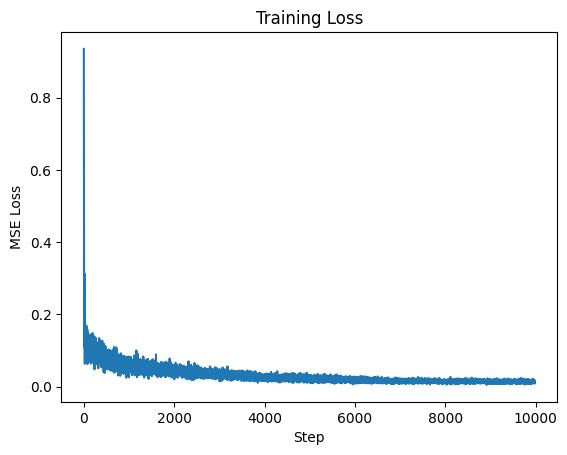

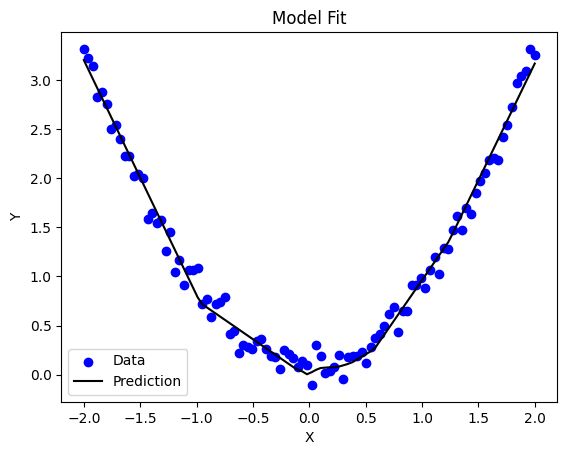

In [ ]:
# Generate synthetic dataset: y = 0.8*x^2 + 0.1 + noise
X = np.linspace(-2, 2, 100)[:, None] # Input features
Y = 0.8 * X**2 + 0.1 + np.random.normal(0, 0.1, size=X.shape) # Target values

# A generator function to yield batches of data for training.
def dataset(batch_size, num_steps):
  for _ in range(num_steps):
    # Randomly sample indices for the batch.
    idx = np.random.choice(len(X), size=batch_size)
    # Yield the corresponding input and target pairs.
    yield X[idx], Y[idx]

# --- Training Loop ---
losses = [] # To store loss values for plotting
# Iterate through the dataset generator for 10,000 steps.
for step, (x_batch, y_batch) in enumerate(
  dataset(batch_size=32, num_steps=10_000)
):
  # CRITICAL: Place the NumPy data onto JAX devices AND apply sharding.
  # named_sharding('data') -> Shard along the 'data' mesh axis (first dim, size 2).
  # Each device along the 'data' axis gets a slice of the batch.
  x_batch, y_batch = jax.device_put((x_batch, y_batch), named_sharding('data'))

  # Execute the JIT-compiled training step with the sharded model, optimizer, and data.
  loss = train_step(model, optimizer, x_batch, y_batch)

  # Record the loss (move scalar loss back to host CPU).
  losses.append(float(loss))
  # Log progress periodically.
  if step % 1000 == 0:
    print(f'Step {step}: Loss = {loss}')

# --- Plotting Results ---
plt.figure()
plt.title("Training Loss")
plt.plot(losses[20:]) # Plot loss, skipping initial noisy steps
plt.xlabel("Step")
plt.ylabel("MSE Loss")

# Get model predictions on the full dataset (X is on host CPU).
# Model applies function executes potentially on device, result brought back implicitly.
y_pred = model(X)
plt.figure()
plt.title("Model Fit")
plt.scatter(X, Y, color='blue', label='Data') # Original data
plt.plot(X, y_pred, color='black', label='Prediction') # Model's predictions
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show() # Display the plots